# Test GenomeOcean-meta-4B

This notebook demonstrate the following functions:

  1. Scoring genomic sequence datasets. We ask the model whether it thinks a dataset is similar to its training data.
  2. Generating artifical sequences. We generate artificial sequences and evaluate their quality using various quality
  3. Test the model for its ability to recognize mutations to natural sequences
  

  Requirements:
  
  - A model directory
  - This notebook runs on NERSC's pytorch-2.01 kernel, you may need to install some packages such as transformers.To install a package, run the following in a cell:
```
! pip install package_name
```

## 0. Load libraries

In [1]:
import os
import numpy as np
import transformers
import torch
import torch.utils.data as util_data
import torch.nn as nn
import tqdm
import argparse

from torch.utils.data import Dataset
import pandas as pd

In [2]:
# set it to prevent the warning message when use the model
os.environ['TOKENIZERS_PARALLELISM'] = 'true'

In [3]:
def compute_perplexity(dna_sequences, model_dir, use_ppl=False):
    print(f"Getting perplexity for {len(dna_sequences)} sequences")
    print(f"Model directory: {model_dir}")
    
    tokenizer = transformers.AutoTokenizer.from_pretrained(model_dir)
    model = transformers.AutoModelForCausalLM.from_pretrained(
        model_dir,
        trust_remote_code=True,
        torch_dtype=torch.bfloat16, 
        attn_implementation="flash_attention_2",
    )
    
    model.to("cuda")
    

    encodings = tokenizer(dna_sequences, 
                        padding=False,)

    max_length = 1024 # current max length of the model
    stride = 512
    device = "cuda"
    
    perplexities = np.zeros(len(dna_sequences))

    for i, sample in tqdm.tqdm(enumerate(encodings["input_ids"])):
        nlls = []
        prev_end_loc = 0
        sample = torch.tensor(sample).unsqueeze(0)
        seq_len = sample.size(1)
        for begin_loc in range(0, seq_len, stride):
            end_loc = min(begin_loc + max_length, seq_len)
            trg_len = end_loc - prev_end_loc  # may be different from stride on last loop
            input_ids = sample[:, begin_loc:end_loc].to(device)
            target_ids = input_ids.clone()
            target_ids[:, :-trg_len] = -100

            with torch.no_grad():
                outputs = model(input_ids, labels=target_ids)

                # loss is calculated using CrossEntropyLoss which averages over valid labels
                # N.B. the model only calculates loss over trg_len - 1 labels, because it internally shifts the labels
                # to the left by 1.
                neg_log_likelihood = outputs.loss

            nlls.append(neg_log_likelihood)

            prev_end_loc = end_loc
            if end_loc == seq_len:
                break
        
        losses = torch.stack(nlls).mean()
        score = torch.exp(losses).item() if use_ppl else losses.item()
        perplexities[i] = score
    
    return perplexities

def generate_sequences(
    model_dir,
    dna_sequences=None,
    num_generation_in_total=10,
    num_generation_from_each_prompt=4,
    temperature=0.7,
    min_length=128,
    max_length=1024, 
    top_k=50,          
    penalty_alpha=0.6,
):
    

    tokenizer = transformers.AutoTokenizer.from_pretrained(model_dir)
    model = transformers.AutoModelForCausalLM.from_pretrained(
        model_dir,
        trust_remote_code=True,
        torch_dtype=torch.bfloat16, 
        attn_implementation="flash_attention_2",
    )
    
    model.to("cuda")
    
    if dna_sequences is None:
        dna_sequences = ["" for _ in range(num_generation_in_total)]
        num_generation_from_each_prompt = 1
        print(f"No prompt provided. Will generate {num_generation_in_total} sequences")
    else:
        print(f"Will generate {num_generation_from_each_prompt * len(dna_sequences)} sequences from {len(dna_sequences)} prompts")
        
    class MyDataset(Dataset):
        def __init__(self, dna_sequences):
            self.dna_sequences = dna_sequences
            
        def __len__(self):
            return len(self.dna_sequences)

        def __getitem__(self, i):
            return self.dna_sequences[i]

    outputs = []
    dataset = MyDataset(dna_sequences=dna_sequences)
    train_loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False, num_workers=1)
    for i, sequence in enumerate(tqdm.tqdm(train_loader)):
        with torch.no_grad():
            input_ids = tokenizer(sequence, return_tensors='pt')["input_ids"][:, :-1].to("cuda")       
            model_output = model.generate(
                input_ids=input_ids,
                min_length=min_length,
                max_length=max_length,
                do_sample=True,
                top_k=top_k,
                temperature=temperature,
                num_return_sequences=num_generation_from_each_prompt,
                bad_words_ids=[[8]], # N-containing BPE token
                penalty_alpha=penalty_alpha,
            ).cpu().numpy().tolist()
            for text in model_output:
                text = tokenizer.decode(text, skip_special_tokens=True).replace(" ", "").replace("\n", "")
                outputs.append(text)
    
    return outputs

In [4]:
from Bio import Entrez, SeqIO
Entrez.email = "zhongwang@lbl.gov"

def search_gene(gene_name='replicase', organism='Tobacco mosaic virus', database='nucleotide', max_records=10):
    """
    Search for gene records in NCBI database and retrieve GenBank files.

    Args:
        gene_name (str): Name of the gene to search for.
        database (str): NCBI database to search in. Default is "nucleotide".
        max_records (int): Maximum number of records to fetch. Default is 10.

    Returns:
        list: Filenames of the downloaded GenBank files.
    """
    search_term = f'"{gene_name}" AND "{organism}"[Organism] AND "complete cds"'
    
    # Search in the specified database
    search_handle = Entrez.esearch(db=database, term=search_term, retmax=max_records)
    search_results = Entrez.read(search_handle)
    search_handle.close()
    
    # Fetch details for each ID
    ids = search_results['IdList']
    sequences = []
    
    if ids:
        fetch_handle = Entrez.efetch(db=database, id=",".join(ids), rettype="gb", retmode="text")
        records = list(SeqIO.parse(fetch_handle, "genbank"))
        fetch_handle.close()

        for i, record in enumerate(records):
            if record.seq:
                sequences.append(str(record.seq))
            else:
                print(f"Record {i} does not contain sequence data.")
    else:
        print("No records found for the specified gene.")

    return sequences

In [5]:
# Change this to the directory of the model
model_dir = "/global/homes/z/zhwang/RD_cfs/projects/LLMs/genomeocean/MOE_DNA/mistral_4B_1024_add1/checkpoint-55000"

## 1. Perplexity Score Distributions

In [9]:
import gzip
def plot_dataset_perplexity(data, num_seqs=1000, min_seq_len=1500, max_seq_len=3000):
    """sample a dataset and plot its perplexity distribution"""
    seqs = {}
    counter = 0
    if data[:-3] == gzip:
        with gzip.open(data, 'rt') as FA:
            for s in SeqIO.parse(FA, 'fasta'):
                if counter >= num_seqs:
                    break
                if len(s.seq) < min_seq_len:
                    continue
                seqs[s.id] = str(s.seq)[0:max_seq_len].upper()
                counter +=1
    else:
        with open(data, 'rt') as FA:
            for s in SeqIO.parse(FA, 'fasta'):
                if counter >= num_seqs:
                    break
                if len(s.seq) < min_seq_len:
                    continue                    
                seqs[s.id] = str(s.seq)[0:max_seq_len].upper()
                counter +=1        
    seqs = pd.DataFrame.from_dict(seqs, orient='index', columns=['seq'])
    seqs['score'] = compute_perplexity(list(seqs['seq']), model_dir=model_dir, use_ppl=False)
    return seqs


### in training

In [7]:
%%capture
data = '/global/homes/z/zhwang/RD_cfs/zhwang/metagenomic_datasets/harvardforest.fa'
scores = plot_dataset_likelihood(data, num_seqs=2000, max_seq_len=5000)

You are attempting to use Flash Attention 2.0 with a model not initialized on GPU. Make sure to move the model to GPU after initializing it on CPU with `model.to('cuda')`.


<Axes: >

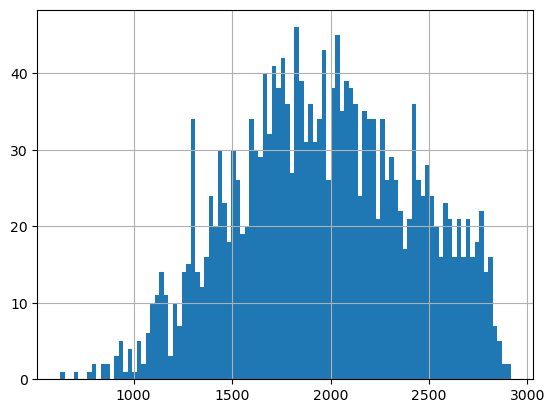

In [8]:
# negative log10 likelihood
scores['score'].hist(bins=100)

In [18]:
# most likely sequences
most_likely_seqs = list(scores.loc[scores['score']<1000, 'seq'])
from Bio.SeqUtils import GC
[GC(s) for s in most_likely_seqs]

[60.24,
 68.92,
 67.76,
 62.96,
 64.64,
 67.06,
 62.54,
 56.98,
 71.88,
 63.14,
 63.26,
 62.8,
 65.66,
 69.28,
 58.2,
 65.76,
 55.78,
 63.14,
 67.52,
 62.96,
 64.52,
 63.18]

In [20]:
most_likely_seqs[16]

'TGGCGAAAGAGAAATTTGACCGCACCAAGCCGCACTGCAATGTAGGGACGATTGGTCACATTGACCATGGGAAGACGACGTTGACGGCGGCGATCACGAAGGTATTGTCGAAGCACAATCCGAAGATCGTGTTCCGGTCGTTCGATTCGATCGACAACGCGCCGGAAGAGAAGGCGCGCGGGATCACGATTGCCACGGCGCACGTGGAGTATGAGACGGCGAACCGGCACTACGCGCACGTGGATTGCCCGGGCCACGCCGACTACATCAAGAACATGATCACGGGCGCGGCGCAGATGGATGGCGGGATTCTGGTAGTTGCTGCGACGGACGGTCCGATGCCGCAGACGCGCGAGCACGTGCTGCTGGCGCGGCAGGTGGGCGTGCCGTATCTGGTGGTTGCGCTGAACAAGTGCGATGCAGTGGATGATCCCGAGCTGCTCGAACTGGTGGAACTGGAAGTGCGCGAATTGCTGAAGAGCTACAAGTTTCCGGGCGACGACGTGCCGGTGGTAAAGGTGTCGGCGCTGGGAGCGTTGAACGGAGAAGAGAAGTGGGAGAAGCAGATTGACGCGCTGATGGAGGCGGTGGACAAGAGCGTGCCGCAGCCGGCGCGCGAGCTCGACAAGCCGTTCCTGATGCCGATTGAAGATATCTTCTCGATTCAAGGGCGCGGCACGGTGGTGACGGGCCGTATTGAGCGCGGCAAGGTGAAGGTGGGCGAGGAAGTAGAGATCGTGGGCTTCCGCGACACGCGCAAGACGGTGGTCACGGGCGTGGAAATGTTCAAGAAGCAATTGGACGAAGGCATGGCGGGCGACAATGCGGGCCTGCTGCTGCGCGGCATTGCGAAAGAGGATGTGGAGCGCGGCATGGTGCTGGCCAAGACGGGATCGATCACGCCGCACACCAAGTTCAAGGCGGAGGTCTACATTCTGACGAAAGAAGAAGGTGGGCGACATACGCCGTTCTTCAAAGGGTATCGTCCACAGTTTTATC

Getting perplexity for 2000 sequences
Model directory: /global/homes/z/zhwang/RD_cfs/projects/LLMs/genomeocean/MOE_DNA/mistral_4B_1024_add1/checkpoint-55000
Using flast_attn 2
flash_attn_func supports window_size: True


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

2000it [02:12, 15.08it/s]


<Axes: >

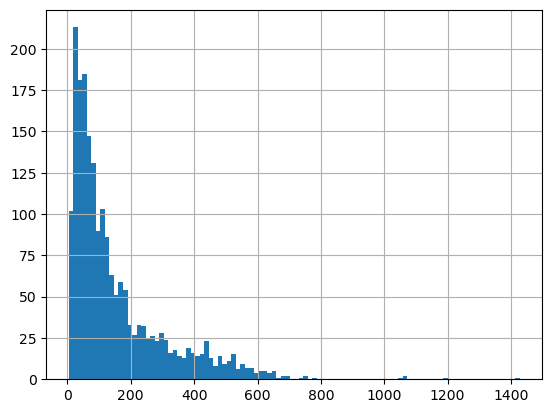

In [9]:
ppls = plot_dataset_perplexity(data, num_seqs=2000, max_seq_len=5000)
ppls['score'].hist(bins=100)

In [19]:
# most unpredictable sequence
most_unpredictable_seqs = list(ppls.loc[ppls['score']>600, 'seq'])
[GC(s) for s in most_unpredictable_seqs]

[35.88,
 41.32,
 59.82,
 56.76,
 52.84,
 49.46,
 41.54,
 59.54,
 47.6,
 51.74,
 58.06,
 51.82,
 54.46,
 56.3,
 55.18,
 56.44,
 62.18,
 57.82,
 60.14,
 49.88,
 52.66,
 54.12,
 41.06,
 52.38,
 54.26,
 63.62,
 56.96,
 54.5,
 49.36,
 63.82,
 46.86,
 53.22,
 47.3,
 61.18]

In [21]:
most_unpredictable_seqs[0]

'ACTTCAAAGCTTTCTGCCGCATATTCCGGATATGAACTGATGAAGATAACGAGAGGCGGTTCTGCTAATAATTTAATAGCAGCAATGCCATTTATACCAGGCATTTTAATATCAGAGATTATCAAATCTGTTTTGTTTTCTTTAATGAATATAATGGCTTCGATAGGGTTTGAAAAACTACCTATCACATTAATGTAGGATATTTCCTTCAGCTCATTGATTAAATGTTGCAGATCTTCCTTGTTATCTTCTAATAAAACTGTTTTTATACTCATGCGTGTATTTGTAAATAAGCGGTGGCTACATTGTTATTGAATTCTATTCTTAATTTGTAATTGTTCTGTTTGGCTAAATCTTCGCATAACTTGATGCCGATACCCGTACCAGCCTCTATTACTTCAGAACAAGTGTTTACAATACTAATCTCATTTCCTGTTTGGGATATTAAAATAGTTTCAGATTCATTCGCATATTTTGATGCATTGGTCAGGAGATTTCTTAATATGACAAGTGTAGTATCATAATCACCTGTAAAAGTAAAAGCTTCATCCATGTTCACCCTGACCCTCTGATTCTTGCTATTAACTAAATAAGCAGTTTGATTAATAACTTCTTCTATTATTTTGGATAAAATTATTTTTACAGGGGTTAATTGGCTCTTGTTTAGTTGGGGATAGCTCCAGTGAAGCAAGTTGTCCAGAATATTCAAAGCACTTAAGGCCTTATTCTTCGCATCCGAATTATTGTTTACAATGGAGCTGATAGGGCTTCGCAAATCGTGCGATATAATGGTAAACACATTGTTTTTAAAGTCATTTAATTCTGATAGCTCCTTATTCAATCTTCTTTGCTTTCTGACTAAATAGGAGGTTAACACTACGATGAGCACAGTCAAAATAAACAAAGCAGAAATAAAATAAATCCTTGTGTTCTGTTTTTGTATTAAAAAATTCTTTTCTGTAATATCAGTTTTGTCTTTTAAAAGTTCGTTGTCTTTCT

In [22]:
np.corrcoef(ppls['score'], scores['score'])

array([[1.        , 0.83485576],
       [0.83485576, 1.        ]])

In [ ]:
plot_dataset_perplexity

In [23]:
data = '/global/homes/z/zhwang/RD_cfs/zhwang/metagenomic_datasets/antarctic.fa'
scores = plot_dataset_perplexity(data, num_seqs=2000, max_seq_len=5000)

Getting perplexity for 2000 sequences
Model directory: /global/homes/z/zhwang/RD_cfs/projects/LLMs/genomeocean/MOE_DNA/mistral_4B_1024_add1/checkpoint-55000
Using flast_attn 2
flash_attn_func supports window_size: True


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

2000it [01:34, 21.11it/s]


<Axes: >

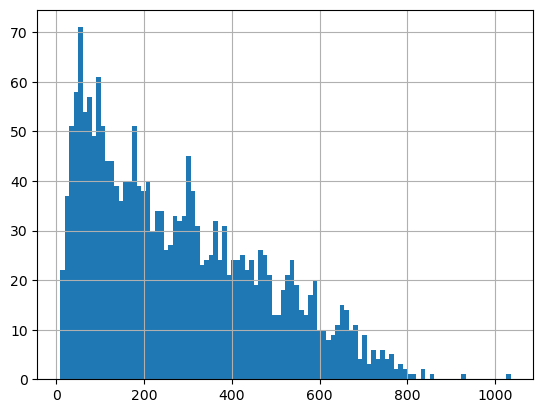

In [24]:
# negative log10 likelihood
scores['score'].hist(bins=100)

### not in training

Getting perplexity for 2000 sequences
Model directory: /global/homes/z/zhwang/RD_cfs/projects/LLMs/genomeocean/MOE_DNA/mistral_4B_1024_add1/checkpoint-55000
Using flast_attn 2
flash_attn_func supports window_size: True


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

2000it [01:06, 30.26it/s]


,seq,score
contig_21_51809_length_285_multi_3_in_0_out_0,TTTAGAATGCAAATTAACCACGTCTCCCCAATTTACAGGGTGTCCT...,6.193606
contig_21_220299_length_217_multi_2_in_0_out_0,TCTGTCATGTGTCAGATCGCGGGGCTTGGAAGAATCAGAGAGATCC...,6.586954
contig_21_317047_length_216_multi_2_in_0_out_0,CTAAACGAGGCATGAGACTGTCCAAGTTTAGAGAGAGATGAATGGA...,6.635801
contig_21_372421_length_215_multi_2_in_0_out_0,GAAACCTTTGATGCCAATCGTGAGTTAACCGGACTGGGTCTGGCCA...,5.230331
contig_21_389648_length_230_multi_1_in_0_out_0,ACAGGCATCTATTATATCTCGCAGCCGGATACTAAAATCCTCACGC...,6.420990
...,...,...
contig_21_181260191_length_255_multi_3_in_0_out_0,AAGGATATATCAATGGTGGCATTAACACTATCGAGAAGATTATCAG...,6.506928
contig_21_181277432_length_267_multi_2_in_0_out_0,AGTCTGCTACTGACCGTATTTACGTCGGTCACGGCAGAGACCGCGA...,6.855075
contig_21_181325485_length_201_multi_3_in_0_out_0,ATCTTTTGTCAAAAGACTGGACAAATGCCAGCGACCCCTGGTGGAT...,6.867580
contig_21_181351551_length_201_multi_4_in_0_out_0,TAAACACTGGAAGTTCCCTCAGAACAGTCCACAGAAAGTCAGTTTG...,6.280696


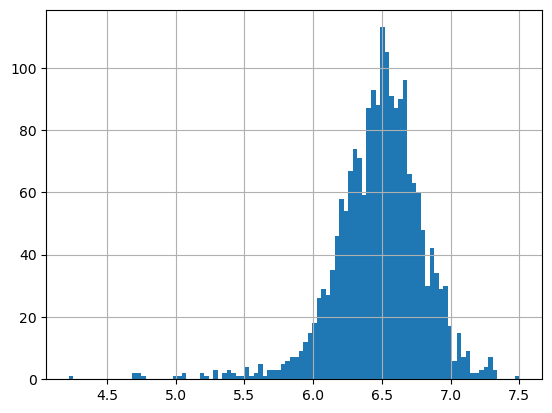

In [22]:
data = '/global/homes/z/zhwang/RD_cfs/zhwang/metagenomic_datasets/sheeprumen.fa'
scores = plot_dataset_perplexity(data, num_seqs=2000, max_seq_len=5000)

Getting perplexity for 2000 sequences
Model directory: /global/homes/z/zhwang/RD_cfs/projects/LLMs/genomeocean/MOE_DNA/mistral_4B_1024_add1/checkpoint-55000
Using flast_attn 2
flash_attn_func supports window_size: True


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

2000it [03:34,  9.34it/s]


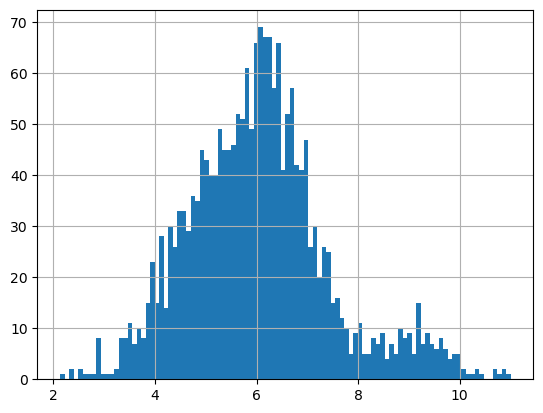

In [25]:
# similar dataset in the training
data = '/global/dna/projectdirs/RD/Metagenome_RD/Trout_Bog_Lake_metagenome/Contigs/Epilimnion/10681.assembled.fna'
scores = plot_dataset_perplexity(data, num_seqs=2000, max_seq_len=5000)

Getting perplexity for 2000 sequences
Model directory: /global/homes/z/zhwang/RD_cfs/projects/LLMs/genomeocean/MOE_DNA/mistral_4B_1024_add1/checkpoint-55000
Using flast_attn 2
flash_attn_func supports window_size: True


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

2000it [02:52, 11.59it/s]


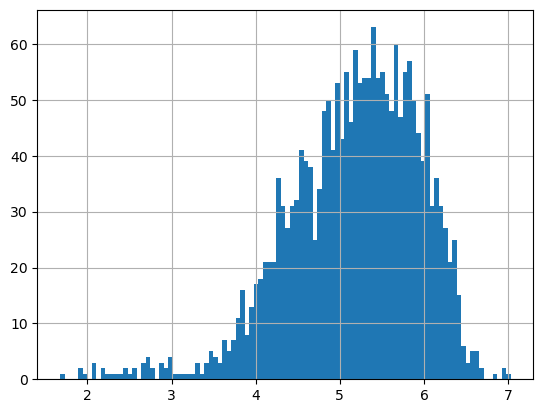

In [28]:
data = '/global/dna/projectdirs/RD/Metagenome_RD/Arctic/spades/scaffolds.fasta'
scores = plot_dataset_perplexity(data, num_seqs=2000, max_seq_len=5000)

Getting perplexity for 2000 sequences
Model directory: /global/homes/z/zhwang/RD_cfs/projects/LLMs/genomeocean/MOE_DNA/mistral_4B_1024_add1/checkpoint-55000
Using flast_attn 2
flash_attn_func supports window_size: True


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

2000it [02:27, 13.56it/s]


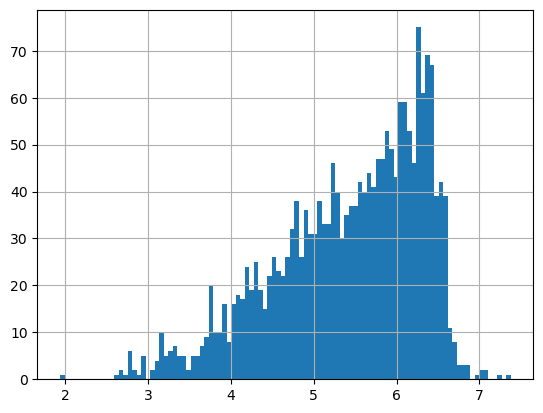

In [32]:
data='/global/homes/z/zhwang/RD_cfs/zhwang/metagenomic_datasets/nyc_subway.fa'
scores = plot_dataset_perplexity(data, num_seqs=2000, max_seq_len=5000)

Getting perplexity for 2000 sequences
Model directory: /global/homes/z/zhwang/RD_cfs/projects/LLMs/genomeocean/MOE_DNA/mistral_4B_1024_add1/checkpoint-55000
Using flast_attn 2
flash_attn_func supports window_size: True


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

2000it [01:21, 24.66it/s]


<Axes: >

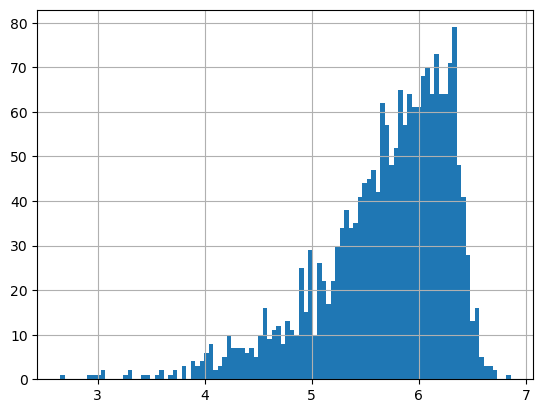

In [10]:
data = '/global/homes/z/zhwang/RD_cfs/zhwang/metagenomic_datasets/hmp2.fa'
scores = plot_dataset_perplexity(data, num_seqs=2000, max_seq_len=5000)
scores['score'].hist(bins=100)

<Axes: >

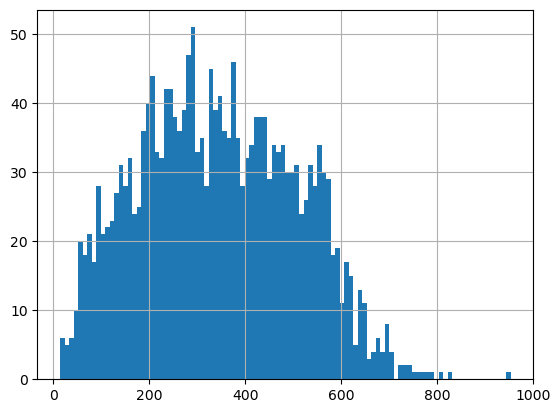

In [8]:
data = '/global/homes/z/zhwang/RD_cfs/zhwang/metagenomic_datasets/hmp2.fa'
scores = plot_dataset_perplexity(data, num_seqs=2000, max_seq_len=5000)
scores['score'].hist(bins=100)

## 2. Generation

In [7]:
import pandas as pd
from Bio import SeqIO
import pyrodigal

### Take one contig, use all of its ORFs, generate 10 sequences from each using 100nt as prompts

Test how likely we can maintain coding regions

In [8]:
orf_finder = pyrodigal.GeneFinder(meta=True)

In [9]:
data = '/global/dna/projectdirs/RD/Metagenome_RD/Trout_Bog_Lake_metagenome/Contigs/Epilimnion/10681.assembled.fna'
with open(data, 'rt') as FA:
    for s in SeqIO.parse(FA, 'fasta'):
        pred = orf_finder.find_genes(bytes(str(s.seq), encoding='utf8'))
        break

In [10]:
with open('temp.fa', 'w') as OUT:
    pred.write_genes(OUT, sequence_id='test')

In [11]:
seqs = []
with open('temp.fa', 'rt') as FA:
    for s in SeqIO.parse(FA, 'fasta'):
        if len(s.seq) > 450:
            seqs.append(str(s.seq))

In [12]:
len(seqs)

147

#### long prompts

In [101]:
lengths = np.array([len(s) for s in seqs])
np.where(lengths > 1200 )

(array([  0,   1,   3,   4,  16,  20,  29,  35,  37,  38,  45,  48,  49,
         51,  52,  53,  54,  55,  56,  57,  58,  66,  67,  72,  76,  77,
         78,  79,  82,  83,  84,  89,  99, 103, 109, 123, 125, 127, 130]),)

In [107]:
prompts = [seqs[s][0:1000] for s in np.where(lengths > 1200)[0] ]

In [109]:
%%capture
g_seqs = generate_sequences(
    model_dir=model_dir,
    dna_sequences=prompts,
    num_generation_in_total=10*len(prompts),
    num_generation_from_each_prompt=10,
    temperature=0.7,
    min_length=300,
    max_length=400, 
    top_k=128, # use more top_k to increase diversity
    penalty_alpha=0.6, # control repeats
)

In [110]:
stop_codons = ['TAA', 'TAG', 'TGA']
def get_orf_len(s):
    for i in range(0, len(s), 3):
        if s[i:i+3] in stop_codons:
            return i+3
    return len(s)

g_seqs = pd.DataFrame(g_seqs).rename(columns={0:'seq'})
g_seqs['orf_len'] = g_seqs['seq'].apply(lambda x: get_orf_len(x))

In [113]:
g_seqs['length'] = g_seqs['seq'].apply(lambda x: len(x))
g_seqs['prompt'] = g_seqs['seq'].apply(lambda x: x[0:1000])
seqs = pd.DataFrame([seqs[s] for s in np.where(lengths > 1200)[0] ]).rename(columns={0:'ori_seq'})
seqs['prompt'] = seqs['ori_seq'].apply(lambda x: x[0:1000])
seqs['ori_len'] = seqs['ori_seq'].apply(lambda x: len(x))
g_seqs = pd.merge(g_seqs, seqs, on='prompt', how='left')
g_seqs.head()

,seq,orf_len,length,prompt,ori_seq,ori_len
0,ATGAGTTCTATCGTAGTTGCTGGAGATACCAGCGGTTCAATCACAT...,1002,1787,ATGAGTTCTATCGTAGTTGCTGGAGATACCAGCGGTTCAATCACAT...,ATGAGTTCTATCGTAGTTGCTGGAGATACCAGCGGTTCAATCACAT...,1614
1,ATGAGTTCTATCGTAGTTGCTGGAGATACCAGCGGTTCAATCACAT...,1002,1786,ATGAGTTCTATCGTAGTTGCTGGAGATACCAGCGGTTCAATCACAT...,ATGAGTTCTATCGTAGTTGCTGGAGATACCAGCGGTTCAATCACAT...,1614
2,ATGAGTTCTATCGTAGTTGCTGGAGATACCAGCGGTTCAATCACAT...,1002,1710,ATGAGTTCTATCGTAGTTGCTGGAGATACCAGCGGTTCAATCACAT...,ATGAGTTCTATCGTAGTTGCTGGAGATACCAGCGGTTCAATCACAT...,1614
3,ATGAGTTCTATCGTAGTTGCTGGAGATACCAGCGGTTCAATCACAT...,1002,1774,ATGAGTTCTATCGTAGTTGCTGGAGATACCAGCGGTTCAATCACAT...,ATGAGTTCTATCGTAGTTGCTGGAGATACCAGCGGTTCAATCACAT...,1614
4,ATGAGTTCTATCGTAGTTGCTGGAGATACCAGCGGTTCAATCACAT...,1002,1791,ATGAGTTCTATCGTAGTTGCTGGAGATACCAGCGGTTCAATCACAT...,ATGAGTTCTATCGTAGTTGCTGGAGATACCAGCGGTTCAATCACAT...,1614


In [114]:
g_seqs.loc[g_seqs['ori_len'] == max(g_seqs['ori_len']), ['length', 'orf_len', 'ori_len', ]]

,length,orf_len,ori_len
270,1312,1002,14580
271,1755,1002,14580
272,1824,1002,14580
273,1801,1002,14580
274,1800,1002,14580
275,1766,1002,14580
276,1390,1002,14580
277,1751,1002,14580
278,1345,1002,14580
279,1560,1002,14580


In [115]:
g_seqs.loc[g_seqs['ori_len'] == min(g_seqs['ori_len']), ['length', 'orf_len', 'ori_len', ]]

,length,orf_len,ori_len
310,1239,1026,1218
311,1794,1389,1218
312,1808,1053,1218
313,1737,1047,1218
314,1748,1032,1218
315,1860,1092,1218
316,1770,1062,1218
317,1773,1023,1218
318,1824,1044,1218
319,1825,1095,1218


In [116]:
g_seqs.loc[g_seqs['ori_len'] == np.median(g_seqs['ori_len']), ['length', 'orf_len', 'ori_len', ]]

,length,orf_len,ori_len
230,1899,1785,1779
231,1873,1873,1779
232,1428,1428,1779
233,1866,1866,1779
234,1381,1381,1779
235,1896,1896,1779
236,1888,1888,1779
237,1895,1895,1779
238,1917,1917,1779
239,1863,1863,1779


In [117]:
fasta = list(g_seqs.loc[g_seqs['ori_len'] == np.median(g_seqs['ori_len']), 'seq'])
fasta = [list(g_seqs.loc[g_seqs['ori_len'] == np.median(g_seqs['ori_len']), 'ori_seq'])[0]] + fasta

In [140]:
from Bio.Seq import translate
# remove prompts
fasta = [translate(fa,to_stop=True) for fa in fasta]

/global/homes/z/zhwang/.local/unknown/pytorch2.0.1/lib/python3.9/site-packages/Bio/Seq.py:2979: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


In [145]:
with open('median_seq.fa', 'w') as FA:
    counter = 0
    for fa in fasta:
        FA.write('>' + str(counter) + '\n')
        FA.write(fa[332:] + '\n')
        counter+=1

### Generate from a pFAM

In [6]:
selected_seq = """ATGGCAGTAAAACTAACAATATGCGATGAAGTAAATATTAAATTTTCTGGATTATCGCTTGATGCAAGAA
AAAAATTAGCAGCAACTTTTAAATATGAAATACCATATGCAAAGTACCAACCAGCATATCGATTAGGTCG
TTGGGATGGTACAGTAAGTTTATTTGGTATAGGTGGCTCTGGATATTTAAGTCAGCTTGAATCTATTTTA
GATATCTTATCTAAGATGGGTATTCAGTTAGATGAAGTAGATGACCAACGCAACCCAATTAATTTAACAT
TTGATGATGTCACCGAAACATATTGGGCAGATCAAGGTAAGGTATGGCCACCTGGGCATCCAACTGAAGG
CGCCCCAATTATGTTGCGTGATTACCAGGTAGCTGCCATTAATAAGTTTTTAAAAAATCCGCAAAGTTTA
CAAGAAATTGCAACAGGCGCTGGTAAATGTCAACCATTGAATAGTCTAGTATTAACGTCTACAGGCTGGA
AAACTATGGGTGATATTAAAATAGGAGATTTGGTGGTTACCCCAACTGGTAAATTATCTAAGGTAATAAG
TGTATTTGAACCTGGTGTTAAAGATATATACCAATTAACATTTTCTGATGGAAGAACTGCTAAATCATGT
AAAGATCATTTATGGAGAGTTCATAATATTGATTGGAAAACTAATTCTGGACATTGGAGAAATATATCTA
CTGAAGAATTGATTAAATTAAAATCAAATACAAAACGTTCTATTGGCATACCATTAGTTTCTATGAAAAA
TAATGATACAGACGTTGACTTACCTATGGATCCATGGTTATTAGGATTTTTACTAGGTGATGGAAGTTTT
AGAAATGGTCGTATTAATTTTAGTACATCAGATTCTGAACTTGTTAACAAGGTTGAATCAAAATTAAATA
ATAGATATAAAGTAAAGCATTTAGGAAAATATGATTACACCATCCAATTTGCAGATTTAAATGACATGAG
AGCCAGTCATTCAGAATTGATGAAAATAAAAAGTAGAAATAAGAATGGTCATATAATAAATAATAACCAT
ACTTCATTAAATGAATATAGACAAATTATTAATGAGTTAGGATTAGGTGAAACATACAGTCACAATAAAT
TTGTCCCAAAAATGTATTTTAATTCCAGCTTTAATCAGAGAATAGAATTAATTAAAGGATTAGTTGATAG
TGACGGAACTGTTGACACCTCTAGTGTAAGTTTTACTTCAGTAAGTAAACAATTAGCGTTAGATTTTCAA
CAATTAATATGGAGTGTTGGTGGGATAGCAAAAATCGCCACTAAAGAAAAGAATACATATAAGTATAATA
ACGATATAAAATTTGGTAAAACGTCATATCGTGTATCAACAAAATATACTACTCCTTGGGAATTGATATC
ATTACAACGAAAAATTGATAAAACAAATTTGTTTTATCAGTATGGACCAACATTAAAGTTAAACATAGAG
CATATTGAAAAAATTGGTTCAGAGGATGTCAAATGTATTCTTATAGATGACCCAGACCATTTATATATTA
CTGACAATTACATTGTTACTCATAATACCATTACTACTGCTACGTTATCCCAAATATGTGAAAAATTTGG
TAGGACAATAATCATTGTTCCAAATAAATCATTGGTTGAACAAACTGAAGAAGATTTTATTAACTGTGGA
TTAGATGTTGGTGTGTACTATGGTGATAGAAAAGATTTATATAAAACACATACTATTTGTACATGGCAAA
GTCTTAATATTTTAGATAAGAAAAGTAAAAATCACGAACACGATATTATATCATTGGCTGAGTTCTTAGA
TAATGTAAAAGCAGTTATAGTTGATGAATGTTTTGATGGTAATGCCAAGGTATTATCTGCAGATGGGTCA
TATGTCCCGATAAAAGATATAAAATCTGGAGATAAAATCATTAATTATTCAGAAGAAACAAAAGCGTTTA
AAGTTGATACAGTTATTAACCAACATAAAAATCTTAACAAATCTAATAATGAAAAAATGTATGAGTTAGA
ATTTGACAATGGTAGTATTATTAAAGTAACCGGAAATCACAAATTCTTAACGACTATTGGTTGGGTGCGT
GCAGATGAGCTTACAGATATGCATTATATTATTAATAAAACATAA"""
selected_seq = selected_seq.replace('\n', '')

In [7]:
len(selected_seq)

2145

In [8]:
prompts = [selected_seq[:1000]]

In [13]:
%%capture
g_seqs = generate_sequences(
    model_dir=model_dir,
    dna_sequences=prompts,
    num_generation_in_total=10*len(prompts),
    num_generation_from_each_prompt=10,
    temperature=0.7,
    min_length=400,
    max_length=500, 
    top_k=128, # use more top_k to increase diversity
    penalty_alpha=0.1, # control repeats
)

In [14]:
stop_codons = ['TAA', 'TAG', 'TGA']
def get_orf_len(s):
    for i in range(0, len(s), 3):
        if s[i:i+3] in stop_codons:
            return i+3
    return len(s)

g_seqs = pd.DataFrame(g_seqs).rename(columns={0:'seq'})
g_seqs['orf_len'] = g_seqs['seq'].apply(lambda x: get_orf_len(x))
g_seqs['length'] = g_seqs['seq'].apply(lambda x: len(x))
g_seqs['prompt'] = g_seqs['seq'].apply(lambda x: x[0:1000])


In [18]:
g_seqs

,seq,orf_len,length,prompt
0,ATGGCAGTAAAACTAACAATATGCGATGAAGTAAATATTAAATTTT...,1056,2206,ATGGCAGTAAAACTAACAATATGCGATGAAGTAAATATTAAATTTT...
1,ATGGCAGTAAAACTAACAATATGCGATGAAGTAAATATTAAATTTT...,1047,2030,ATGGCAGTAAAACTAACAATATGCGATGAAGTAAATATTAAATTTT...
2,ATGGCAGTAAAACTAACAATATGCGATGAAGTAAATATTAAATTTT...,1020,2247,ATGGCAGTAAAACTAACAATATGCGATGAAGTAAATATTAAATTTT...
3,ATGGCAGTAAAACTAACAATATGCGATGAAGTAAATATTAAATTTT...,1047,2317,ATGGCAGTAAAACTAACAATATGCGATGAAGTAAATATTAAATTTT...
4,ATGGCAGTAAAACTAACAATATGCGATGAAGTAAATATTAAATTTT...,1032,1836,ATGGCAGTAAAACTAACAATATGCGATGAAGTAAATATTAAATTTT...
5,ATGGCAGTAAAACTAACAATATGCGATGAAGTAAATATTAAATTTT...,1077,1950,ATGGCAGTAAAACTAACAATATGCGATGAAGTAAATATTAAATTTT...
6,ATGGCAGTAAAACTAACAATATGCGATGAAGTAAATATTAAATTTT...,1113,1740,ATGGCAGTAAAACTAACAATATGCGATGAAGTAAATATTAAATTTT...
7,ATGGCAGTAAAACTAACAATATGCGATGAAGTAAATATTAAATTTT...,2238,2238,ATGGCAGTAAAACTAACAATATGCGATGAAGTAAATATTAAATTTT...
8,ATGGCAGTAAAACTAACAATATGCGATGAAGTAAATATTAAATTTT...,2328,2328,ATGGCAGTAAAACTAACAATATGCGATGAAGTAAATATTAAATTTT...
9,ATGGCAGTAAAACTAACAATATGCGATGAAGTAAATATTAAATTTT...,1056,1980,ATGGCAGTAAAACTAACAATATGCGATGAAGTAAATATTAAATTTT...


In [22]:
from Bio.Seq import translate
# remove prompts
fasta = [translate(fa, to_stop=True)[332:] for fa in g_seqs.loc[g_seqs['orf_len']>2000, 'seq'] ]

In [23]:
fasta

['LNTKNNHQGVIPKSFVLNTSKYNDKLIKGILDSDGSVKNGRNVRLVNYKNQSKDIKDIFLLADYIGFLGKYASINYINNSSTRVKLESLKQYDVNGLIPLLELHKQNIVYGSNRFGYDGLSYNVTEKYTDNELFRLALDYKLADKLILESKKLINNKLTSIKNNHISIYKPIDFKNKFKNIFEFKKYRLVTKYAILDIELKYNINQLIKILKYDIEDKVNKLNRNKFKKLIKNNQIKINNNIYELIKNINISYNKYINISYDRVILPIYCINKKVLSTFGNRNFDFKYKFNTSSNFINNITLIKNFNLTSNTQYGVVGLIAPHNSYMDHFIDCLIALNNIYINKKNIKFKILTGNESDKISKYNIDNNIIYNYNKLNSDIIIIDEDDLINNIKKNINYSVIADPHGNNISHSIS',
 'LIFLRHLGINANEKGYLPKNYIINKIKHRLELLQGLIDTDGFVNKGKNDYYLVTSNKLLVEDVVELCMSLGFEATKRNKRISVKGFAYRKPDNKFTFICNRFEDVKAGKLLLNNKLKYNRSYNENKYVKIINIDNPNVEVYVVTPDSDTFLQGVSTIAKKYKINLAKISINYVNNNFKLEDFKSKIEEKFNKINNDKFNVVIFDSIIDSKTTNKELSKLFNDTEEYKRISKLGEDFVGSDANKILELNDILDYKLDSKLKENLSFERYTTSKTNNLTNENIVDINKFINNYLGLNKLARFITEHINLSTNVLKEHNIDNNVIIRDSIKLLLIQDIGSKLIEEYLKINFDKYKDEIIDKINNYLSNKESKLLYKKILDKSILNDSIINELYNNINSLFNKYDKLFNQIEELSDKINTNKLDNLDKIIKLIKENKLIDIDIDLNNT']

### one with known structure

https://www.rcsb.org/structure/5I5P

>5I5P_1|Chains A, B|TRAP TRANSPORTER SOLUTE BINDING PROTEIN|uncultured marine bacterium (56765)
MHHHHHHSSGVDLGTENLYFQSMEVVLKFHSFPPMPANSNAKFVKPWSEKVLAESNGEIKVEIYPAMQLGGKPPQLVDQVRDGVVDIVWTVAGYTPGRFPHLEAFELPFMPASAEATSQALQEYVDTVAASDLKDYKVLAVFCHAPGKIHTKEKVIKSAADLNGMKMRGPTRVITKMLEGLGATPVGMPVPAVAGALSKGVIDGMVVPWEIMPSFKLHELTKAHTTVSGSRGLYTTPFLFLMNKAKYESLSDEHKKVIDNNAGLALAKLAGQLWDGFEVPARKLALDAGGTIHSLSGGPLAEMKAAGEGLEKDWIKSANDRGLDGAMLVKTAKDLISKYDK


In [2]:
len("MHHHHHHSSGVDLGTENLYFQSMEVVLKFHSFPPMPANSNAKFVKPWSEKVLAESNGEIKVEIYPAMQLGGKPPQLVDQVRDGVVDIVWTVAGYTPGRFPHLEAFELPFMPASAEATSQALQEYVDTVAASDLKDYKVLAVFCHAPGKIHTKEKVIKSAADLNGMKMRGPTRVITKMLEGLGATPVGMPVPAVAGALSKGVIDGMVVPWEIMPSFKLHELTKAHTTVSGSRGLYTTPFLFLMNKAKYESLSDEHKKVIDNNAGLALAKLAGQLWDGFEVPARKLALDAGGTIHSLSGGPLAEMKAAGEGLEKDWIKSANDRGLDGAMLVKTAKDLISKYDK")

341

In [6]:
selected_seq = """GTTCTCATACTTCCTTATCAAGTCGCGTGCAGTTTGCACGAGCATTTCGCCGTCAAGACCGCTCTCGTTG
GCGTCAGCGATCCATTGCTGGACCAAAACCTCTCCGGCTGCCTTCATCTCGTCAAGCGAAGCACCGGACA
GCTCGTGGAATTCTCCACCGGCTTCCACCGCCAGCTGCCGTGCAGGCGCCTCGAATCCGTCCCACAGCTG
GCCAGCCAGCGCTGCCAGCGCCAAGCCGGCATTGTCGTCAATGACCTTCTTGTGGCTGTCCGTCAACGAC
TCGTACTTGGCCTGGTTCATGAGGAACAGGAAAGGGGTGGTGTAAAGGCCGCGATCACCCGACGCCACGG
TGTGCGCCTTGGTCAGTTCATGAAGCTTGAACGAGGGCATGATTTCCCACGGAACGACCATTCCGTCAAT
CACGCCCTTCGACAGGGACGGAGCCACTTCGGGAACCGGCATTCCTACCGGGGTCGCGCCCAAGGCGTCA
AGCATCTGGTTGATCACGCGGGTTGGCGCGCGCATTTTAAGCCCCTTCAAATCGTCCATGGACTTAACGA
GAGTGTCCTTCGTGTGTATCTTGCCGGGCGCGTGGACGAAAACGGCCAATACCTTATAGTCTTTCAGATC
CTCGGCGCCGACCGTCTCAGCATATTCCTGCGCCGCTTGCGAGGTGGCTTCGGCCGAGGCGGCCATGAAC
GGAAGATCGAACACTTCCAAGCGGGGGAACCGTCCGGGGGTATATCCTGCGACCGTCCAGACAATGTCCA
CCACGCCTTCTCGCACTTGGTCCACAAGCTGGGGTGGACTTCCCCCGAGCTGCATGGACGGATAAATCTC
CACGGTGATCTCGCCATTCGATTCCGCTGCGATCTTGTCGGCCCAAGGCTTGACGAAATTGGCATTTGAA
TTCGCGGGCATTGGGGGGAACGAGTGAAATTTCAGCGTGAC"""
selected_seq = selected_seq.replace('\n', '')
len(selected_seq)

951

In [7]:
prompts = [selected_seq[:500]]

In [10]:
%%capture
g_seqs = generate_sequences(
    model_dir=model_dir,
    dna_sequences=prompts,
    num_generation_in_total=20*len(prompts),
    num_generation_from_each_prompt=20,
    temperature=0.7,
    min_length=250,
    max_length=300, 
    top_k=64, # use more top_k to increase diversity
    penalty_alpha=0.1, # control repeats
)

In [11]:
stop_codons = ['TAA', 'TAG', 'TGA']
def get_orf_len(s):
    for i in range(0, len(s), 3):
        if s[i:i+3] in stop_codons:
            return i+3
    return len(s)

g_seqs = pd.DataFrame(g_seqs).rename(columns={0:'seq'})
g_seqs['orf_len'] = g_seqs['seq'].apply(lambda x: get_orf_len(x))
g_seqs['length'] = g_seqs['seq'].apply(lambda x: len(x))
g_seqs['prompt'] = g_seqs['seq'].apply(lambda x: x[0:1000])
g_seqs

,seq,orf_len,length,prompt
0,GTTCTCATACTTCCTTATCAAGTCGCGTGCAGTTTGCACGAGCATT...,576,1335,GTTCTCATACTTCCTTATCAAGTCGCGTGCAGTTTGCACGAGCATT...
1,GTTCTCATACTTCCTTATCAAGTCGCGTGCAGTTTGCACGAGCATT...,1336,1336,GTTCTCATACTTCCTTATCAAGTCGCGTGCAGTTTGCACGAGCATT...
2,GTTCTCATACTTCCTTATCAAGTCGCGTGCAGTTTGCACGAGCATT...,1047,1352,GTTCTCATACTTCCTTATCAAGTCGCGTGCAGTTTGCACGAGCATT...
3,GTTCTCATACTTCCTTATCAAGTCGCGTGCAGTTTGCACGAGCATT...,690,1305,GTTCTCATACTTCCTTATCAAGTCGCGTGCAGTTTGCACGAGCATT...
4,GTTCTCATACTTCCTTATCAAGTCGCGTGCAGTTTGCACGAGCATT...,519,1356,GTTCTCATACTTCCTTATCAAGTCGCGTGCAGTTTGCACGAGCATT...
5,GTTCTCATACTTCCTTATCAAGTCGCGTGCAGTTTGCACGAGCATT...,507,1326,GTTCTCATACTTCCTTATCAAGTCGCGTGCAGTTTGCACGAGCATT...
6,GTTCTCATACTTCCTTATCAAGTCGCGTGCAGTTTGCACGAGCATT...,579,1043,GTTCTCATACTTCCTTATCAAGTCGCGTGCAGTTTGCACGAGCATT...
7,GTTCTCATACTTCCTTATCAAGTCGCGTGCAGTTTGCACGAGCATT...,537,1224,GTTCTCATACTTCCTTATCAAGTCGCGTGCAGTTTGCACGAGCATT...
8,GTTCTCATACTTCCTTATCAAGTCGCGTGCAGTTTGCACGAGCATT...,528,1000,GTTCTCATACTTCCTTATCAAGTCGCGTGCAGTTTGCACGAGCATT...
9,GTTCTCATACTTCCTTATCAAGTCGCGTGCAGTTTGCACGAGCATT...,696,1395,GTTCTCATACTTCCTTATCAAGTCGCGTGCAGTTTGCACGAGCATT...


In [13]:
from Bio.Seq import translate
# remove prompts
fasta = [translate(fa, to_stop=True)[166:] for fa in g_seqs.loc[g_seqs['orf_len']>950, 'seq'] ]
fasta

['VPKNKHQHIIERRGPEACRVAEPCFQPLLRKTVRSLMARLEVIIDRARLGDVGQQALVPCSDAFDVLGRTAESDLAVSEAALDRQAVILHLAGIGDVDLQRAVGQLLHHLGEFGDIVGMEECGRKRAGNVPLRRVLRHRTSHAKREQTGERQASQNSLHVSSRLVLSSVGHPAHRHREPDSRADALCAADLHRAAMALDDRLHDGQTKARAALLAPTGRDIDLVEPVRDTRQMFRRNALAIVVDRDQDVFRIRTQRHDHMAAGFAIGDRVVDQIGEDLG',
 'VIPHKLTLAMASERPSSMAALNTPVWKPKPRAEDDEIRKVFPDRSGLAKRRPSMSASVGMLSFSASAATSSPPNRLAMTVPVYLIWPEAWMAWMVLTLPGEPSWLTGSKVAPGLTAAKASRMPSAHWLPQASAGPLMVAMVRLPSAMAGTASAPDSSAVAARVFRALRRVMEISLLGCQITR',
 'VPLWITRLDAFEIVHRLDRTVSQVDQPIVVGRDEQNFDVFLLGRNVFAIGLEILVDQRQHLRNVGEIGQPIGQVHGADVGDAFQRAIDGSDAQFTAEHPFALDRLAAEDAHVDAALGPFVHAFRKGLEGFVVHAALGITVSETQGDRLLGGKGGAGDGECQRRAREPRHPFHENLPVRLCSCLAERWFSDQTSGGSSS']

In [14]:
fasta = [translate(fa, to_stop=True) for fa in g_seqs.loc[g_seqs['orf_len']>950, 'seq'] ]
fasta

['VLILPYQVACSLHEHFAVKTALVGVSDPLLDQNLSGCLHLVKRSTGQLVEFSTGFHRQLPCRRLESVPQLASQRCQRQAGIVVNDLLVAVRQRLVLGLVHEEQERGGVKAAITRRHGVRLGQFMKLERGHDFPRNDHSVNHALRQGRSHFGNRHSYRGRAQGVKHLVPKNKHQHIIERRGPEACRVAEPCFQPLLRKTVRSLMARLEVIIDRARLGDVGQQALVPCSDAFDVLGRTAESDLAVSEAALDRQAVILHLAGIGDVDLQRAVGQLLHHLGEFGDIVGMEECGRKRAGNVPLRRVLRHRTSHAKREQTGERQASQNSLHVSSRLVLSSVGHPAHRHREPDSRADALCAADLHRAAMALDDRLHDGQTKARAALLAPTGRDIDLVEPVRDTRQMFRRNALAIVVDRDQDVFRIRTQRHDHMAAGFAIGDRVVDQIGEDLG',
 'VLILPYQVACSLHEHFAVKTALVGVSDPLLDQNLSGCLHLVKRSTGQLVEFSTGFHRQLPCRRLESVPQLASQRCQRQAGIVVNDLLVAVRQRLVLGLVHEEQERGGVKAAITRRHGVRLGQFMKLERGHDFPRNDHSVNHALRQGRSHFGNRHSYRGRAQGVKHLVIPHKLTLAMASERPSSMAALNTPVWKPKPRAEDDEIRKVFPDRSGLAKRRPSMSASVGMLSFSASAATSSPPNRLAMTVPVYLIWPEAWMAWMVLTLPGEPSWLTGSKVAPGLTAAKASRMPSAHWLPQASAGPLMVAMVRLPSAMAGTASAPDSSAVAARVFRALRRVMEISLLGCQITR',
 'VLILPYQVACSLHEHFAVKTALVGVSDPLLDQNLSGCLHLVKRSTGQLVEFSTGFHRQLPCRRLESVPQLASQRCQRQAGIVVNDLLVAVRQRLVLGLVHEEQERGGVKAAITRRHGVRLGQFMKLERGHDFPRNDHSVNHALRQGRSHFGNRHSYRGRAQGVKHLVPLWITRLDAFEIVHRLDRTVSQVDQPIV

## 3.Mutation scanning

### Premature Stop

In [120]:
starting_seq = list(g_seqs.loc[g_seqs['ori_len'] == np.median(g_seqs['ori_len']), 'ori_seq'])[0]

In [121]:
starting_seq

'ATGAGCATAGAAGTCAAACAATTAACAGTAAAAAATTTCATGAGTGTTGGCAACCAAACACAGGCTGTAACATTTAATCAAGAAAATTTAACATTAGTATTAGGTGAAAATCTAGATCAAGGTGGTGATGATTCCGGTTCAAGAAATGGCACTGGAAAAACAACTATCGTCAATGCATTGAGTTTTGCATTATATGGAATAGCACTAACTAATATTAAAAAAGATAATCTTATAAACAAGATTAACAATAAAAATATGTTAGTTACACTAACATTTTCAAAAGATGGAGTTGATTATAAAATTGAAAGAGGTAGAAAACCTGCTATTTTTAATTTTATAAATCTTGCAGATCCATCCAAAGTTGAAGAAAGTGATAGCCAAGGTGAATCAAAAGATACTCAAAAAGATATTGAAACATTATTTGGTATGAGTCATAATATGTTCAAACATATAGTAGCATTGAATACTTATACTGACCCATTCTTATCAATGAGGGCGGGTGATCAGCGTGAAATAATTGAGCAATTACTTGGTATCACTTTGCTAAGTGAAAAAGCAGAAATTCTTAGTAAAGAAATTAAGCAAACAAAAGAGTTGATTTTTCAAGAAAATGCAAATATTGAAGCAATGAAAAAATCCAATGAAAAAATTAAACAAAGTATTGATTCATTAACAATGAGTCAACGTTCTTGGAATTTGAAACATAATAATGAACTTCAAAAACTTGGTGAATCTATTGTAAATTTGGAAGGATTAGATTTGACTGCAGAATTATTAGCGCATAATGAATTAAAATCATACTATGAACTTTCTACAAAAATTAGCAGTTTAAATAAAGAAAAAGCAACCTTAGAAGCAGCAATTGAACAAGCAAATAAAAATCATGATAATTATATTAATCATGTAGCAGTTGTAGAATCAAAAATATGCCCAGCATGTGCTCAAGAACTACAAGATCATACACATGAAGATATGTTAGAATCTAGTAAAAATACAGTT

In [122]:
def premature_stop(s, stop_codon = 'TAA'):
    """ sequentially change every codon to stop """
    mutations = []
    for i in range(0, len(s)-3, 3):
        mutations.append(s[0:i] + stop_codon + s[i+3:])
    return mutations

In [123]:
mutations = premature_stop(starting_seq)

In [124]:
len(mutations)

592

Getting perplexity for 592 sequences
Model directory: /global/homes/z/zhwang/RD_cfs/projects/LLMs/genomeocean/MOE_DNA/mistral_4B_1024_add1/checkpoint-55000
Using flast_attn 2
flash_attn_func supports window_size: True


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

592it [00:18, 31.43it/s]


array([[<Axes: title={'center': '0'}>]], dtype=object)

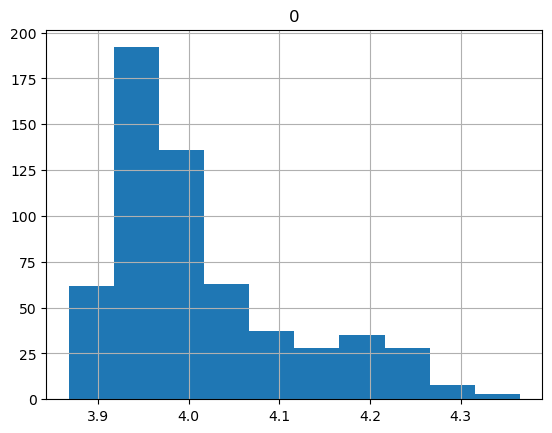

In [125]:
scores = compute_perplexity(mutations, model_dir=model_dir)
pd.DataFrame(scores).hist()

In [126]:
import matplotlib.pyplot as plt

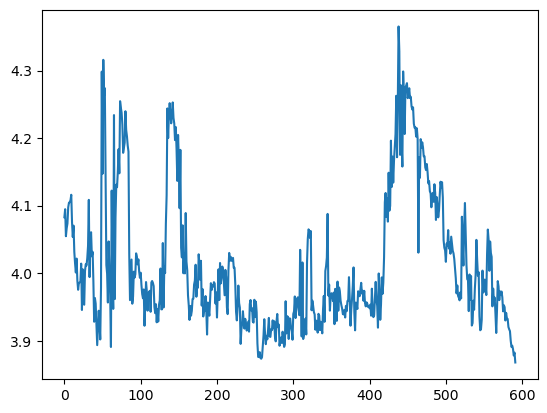

In [127]:
plt.plot(scores)

In [ ]:
%%bash
# check if generated sequences are in training
for i in `ls /global/homes/z/zhwang/RD_cfs/zhwang/metagenomic_datasets/*.fa`;do j="$(basename -- $i)"; cmd="/global/homes/z/zhwang/bin/minimap2 ${i} query.fa"; $cmd > query.sam; done; 

### synonymous vs nonsynonymous mutations

In [42]:
import random
from Bio.Seq import Seq
from Bio.Data import CodonTable

def introduce_mutations(orf_sequence, mutation_percentage=5, mutation_type='synonymous', codontable=11):
    # 11. The Bacterial, Archaeal and Plant Plastid Code (transl_table=11)
    codon_table = CodonTable.unambiguous_dna_by_id[codontable]
    codons = [orf_sequence[i:i+3] for i in range(0, len(orf_sequence), 3)]
    
    num_codons_to_mutate = int(len(codons) * mutation_percentage / 100)
    codons_to_mutate = random.sample(range(len(codons)), num_codons_to_mutate)
    for index in codons_to_mutate:
        original_codon = codons[index]
        amino_acid = codon_table.forward_table.get(original_codon, None)
        if amino_acid:
            if mutation_type=='synonymous':
                candidate_codons = [codon for codon, aa in codon_table.forward_table.items() if aa == amino_acid and codon != original_codon]
            else:
                candidate_codons = [codon for codon, aa in codon_table.forward_table.items() if aa != amino_acid]
            if candidate_codons:
                codons[index] = random.choice(candidate_codons)
    
    mutated_sequence = ''.join(codons)
    return mutated_sequence


In [32]:
selected_seq = """ATGGCAGTAAAACTAACAATATGCGATGAAGTAAATATTAAATTTTCTGGATTATCGCTTGATGCAAGAA
AAAAATTAGCAGCAACTTTTAAATATGAAATACCATATGCAAAGTACCAACCAGCATATCGATTAGGTCG
TTGGGATGGTACAGTAAGTTTATTTGGTATAGGTGGCTCTGGATATTTAAGTCAGCTTGAATCTATTTTA
GATATCTTATCTAAGATGGGTATTCAGTTAGATGAAGTAGATGACCAACGCAACCCAATTAATTTAACAT
TTGATGATGTCACCGAAACATATTGGGCAGATCAAGGTAAGGTATGGCCACCTGGGCATCCAACTGAAGG
CGCCCCAATTATGTTGCGTGATTACCAGGTAGCTGCCATTAATAAGTTTTTAAAAAATCCGCAAAGTTTA
CAAGAAATTGCAACAGGCGCTGGTAAATGTCAACCATTGAATAGTCTAGTATTAACGTCTACAGGCTGGA
AAACTATGGGTGATATTAAAATAGGAGATTTGGTGGTTACCCCAACTGGTAAATTATCTAAGGTAATAAG
TGTATTTGAACCTGGTGTTAAAGATATATACCAATTAACATTTTCTGATGGAAGAACTGCTAAATCATGT
AAAGATCATTTATGGAGAGTTCATAATATTGATTGGAAAACTAATTCTGGACATTGGAGAAATATATCTA
CTGAAGAATTGATTAAATTAAAATCAAATACAAAACGTTCTATTGGCATACCATTAGTTTCTATGAAAAA
TAATGATACAGACGTTGACTTACCTATGGATCCATGGTTATTAGGATTTTTACTAGGTGATGGAAGTTTT
AGAAATGGTCGTATTAATTTTAGTACATCAGATTCTGAACTTGTTAACAAGGTTGAATCAAAATTAAATA
ATAGATATAAAGTAAAGCATTTAGGAAAATATGATTACACCATCCAATTTGCAGATTTAAATGACATGAG
AGCCAGTCATTCAGAATTGATGAAAATAAAAAGTAGAAATAAGAATGGTCATATAATAAATAATAACCAT
ACTTCATTAAATGAATATAGACAAATTATTAATGAGTTAGGATTAGGTGAAACATACAGTCACAATAAAT
TTGTCCCAAAAATGTATTTTAATTCCAGCTTTAATCAGAGAATAGAATTAATTAAAGGATTAGTTGATAG
TGACGGAACTGTTGACACCTCTAGTGTAAGTTTTACTTCAGTAAGTAAACAATTAGCGTTAGATTTTCAA
CAATTAATATGGAGTGTTGGTGGGATAGCAAAAATCGCCACTAAAGAAAAGAATACATATAAGTATAATA
ACGATATAAAATTTGGTAAAACGTCATATCGTGTATCAACAAAATATACTACTCCTTGGGAATTGATATC
ATTACAACGAAAAATTGATAAAACAAATTTGTTTTATCAGTATGGACCAACATTAAAGTTAAACATAGAG
CATATTGAAAAAATTGGTTCAGAGGATGTCAAATGTATTCTTATAGATGACCCAGACCATTTATATATTA
CTGACAATTACATTGTTACTCATAATACCATTACTACTGCTACGTTATCCCAAATATGTGAAAAATTTGG
TAGGACAATAATCATTGTTCCAAATAAATCATTGGTTGAACAAACTGAAGAAGATTTTATTAACTGTGGA
TTAGATGTTGGTGTGTACTATGGTGATAGAAAAGATTTATATAAAACACATACTATTTGTACATGGCAAA
GTCTTAATATTTTAGATAAGAAAAGTAAAAATCACGAACACGATATTATATCATTGGCTGAGTTCTTAGA
TAATGTAAAAGCAGTTATAGTTGATGAATGTTTTGATGGTAATGCCAAGGTATTATCTGCAGATGGGTCA
TATGTCCCGATAAAAGATATAAAATCTGGAGATAAAATCATTAATTATTCAGAAGAAACAAAAGCGTTTA
AAGTTGATACAGTTATTAACCAACATAAAAATCTTAACAAATCTAATAATGAAAAAATGTATGAGTTAGA
ATTTGACAATGGTAGTATTATTAAAGTAACCGGAAATCACAAATTCTTAACGACTATTGGTTGGGTGCGT
GCAGATGAGCTTACAGATATGCATTATATTATTAATAAAACATAA"""
selected_seq = selected_seq.replace('\n', '')[:-3] # remove stop

In [47]:
syn_mutations = [selected_seq]
for i in range(10):
    syn_mutations.append(introduce_mutations(selected_seq,  mutation_type='synonymous', mutation_percentage=20)) 
                         
scores = compute_perplexity(syn_mutations, model_dir=model_dir)
scores

Getting perplexity for 11 sequences
Model directory: /global/homes/z/zhwang/RD_cfs/projects/LLMs/genomeocean/MOE_DNA/mistral_4B_1024_add1/checkpoint-55000
Using flast_attn 2
flash_attn_func supports window_size: True


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

11it [00:00, 27.90it/s]


array([5.30322313, 5.62305784, 5.46152782, 5.55770016, 5.57950687,
       5.51888275, 5.57065201, 5.62492228, 5.70342779, 5.6183486 ,
       5.45914364])

In [48]:
nonsyn_mutations = [selected_seq]
for i in range(10):
    nonsyn_mutations.append(introduce_mutations(selected_seq,  mutation_type='nonsynonymous', mutation_percentage=20)) 
                         
scores = compute_perplexity(syn_mutations, model_dir=model_dir)
scores

Getting perplexity for 11 sequences
Model directory: /global/homes/z/zhwang/RD_cfs/projects/LLMs/genomeocean/MOE_DNA/mistral_4B_1024_add1/checkpoint-55000
Using flast_attn 2
flash_attn_func supports window_size: True


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

11it [00:00, 28.94it/s]


array([5.30322313, 5.62305784, 5.46152782, 5.55770016, 5.57950687,
       5.51888275, 5.57065201, 5.62492228, 5.70342779, 5.6183486 ,
       5.45914364])